In [21]:
pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [22]:
!pip install pytesseract

Defaulting to user installation because normal site-packages is not writeable


In [40]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
import matplotlib.image as mpimg

from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [24]:
import tensorflow as tf
print(tf.__version__)

2.13.1


In [25]:
imagepath = glob('input/images/*.xml')
labelDict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in imagepath:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labelDict['filepath'].append(filename)
    labelDict['xmin'].append(xmin)
    labelDict['xmax'].append(xmax)
    labelDict['ymin'].append(ymin)
    labelDict['ymax'].append(ymax)

In [26]:
dataframe = pd.DataFrame(labelDict)
dataframe.to_csv('labels.csv',index=False)
dataframe.head()

,filepath,xmin,xmax,ymin,ymax
0,input/images\N1.xml,1093,1396,645,727
1,input/images\N100.xml,134,301,312,350
2,input/images\N101.xml,31,139,128,161
3,input/images\N102.xml,164,316,216,243
4,input/images\N103.xml,813,1067,665,724


In [27]:
file_name = dataframe['filepath'][0]
def getFilename(file_name):
    filename_image = xet.parse(file_name).getroot().find('filename').text
    filepath_image = os.path.join('input/images',filename_image)
    return filepath_image
getFilename(file_name)

'input/images\\N1.jpeg'

In [28]:
imagePath = list(dataframe['filepath'].apply(getFilename))
imagePath[:10]

['input/images\\N1.jpeg',
 'input/images\\N100.jpeg',
 'input/images\\N101.jpeg',
 'input/images\\N102.jpeg',
 'input/images\\N103.jpeg',
 'input/images\\N104.jpeg',
 'input/images\\N105.jpeg',
 'input/images\\N106.jpeg',
 'input/images\\N107.jpeg',
 'input/images\\N108.jpeg']

In [33]:
pip install numpy --upgrade

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


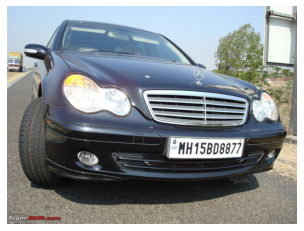

In [41]:
file_path = imagePath[87] #path of our image N2.jpeg
img = cv2.imread(file_path) #read the image
img = io.imread(file_path) #Read the image

plt.imshow(img)
plt.axis('off')  # Optional: Turn off axis labels and ticks
plt.show()

# DATA PROCESSING

In [42]:
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array

labels = dataframe.iloc[:, 1:].values
imgdata = []
output = []

for ind in range(len(imagePath)):
    img = imagePath[ind]
    img_arr = cv2.imread(img)

    if img_arr is None:
        # Handle the case where the image couldn't be loaded
        print(f"Error loading image: {img}")
        continue

    h, w, d = img_arr.shape

    # Preprocessing
    loadImage = load_img(img, target_size=(224, 224))
    loadImage_arr = img_to_array(loadImage)
    norm_loadImage_arr = loadImage_arr / 255.0  # Normalization

    # Normalization to labels
    xmin, xmax, ymin, ymax = labels[ind]
    nxmin, nxmax = xmin / w, xmax / w
    nymin, nymax = ymin / h, ymax / h
    label_norm = (nxmin, nxmax, nymin, nymax)  # Normalized output

    # Append
    imgdata.append(norm_loadImage_arr)
    output.append(label_norm)


Error loading image: input/images\N2.jpeg


In [45]:
#Targeting all our values in array selecting all columns
labels = dataframe.iloc[:,1:].values
imgdata = []
outputList = []
for i in range(len(imagePath)):
    image = imagePath[i]
    img_arr = cv2.imread(image)
    if img_arr is None:
        # Handle the case where the image couldn't be loaded
        print(f"Error loading image: {image}")
        continue

    h, w, d = img_arr.shape
    # Prepprocesing
    loadImage = load_img(image,target_size=(224,224))
    loadImage_arr = img_to_array(loadImage)
    norm_loadImage_arr = loadImage_arr/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[i]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    imgdata.append(norm_loadImage_arr)
    outputList.append(label_norm)

Error loading image: input/images\N2.jpeg


In [46]:
X_data = np.array(imgdata,dtype=np.float32)
y_data = np.array(outputList,dtype=np.float32)

Now split the data into training and testing set using __sklearn__.

In [47]:
# Split the data into training and testing set using sklearn.
x_train,x_test,y_train,y_test = train_test_split(X_data,y_data,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((179, 224, 224, 3), (45, 224, 224, 3), (179, 4), (45, 4))

# INCEPTION-RESNET-V2 MODEL BUILDING


In [48]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
# ---------------------
headmodel = inception_resnet.outputList
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)


# ---------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

219055592/219055592 [==============================] - 12s 0us/step


In [49]:
# Complie model
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

 conv2d_11 (Conv2D)          (None, 25, 25, 64)           12288     ['average_pooling2d[0][0]']   
                                                                                                  
 batch_normalization_5 (Bat  (None, 25, 25, 96)           288       ['conv2d_5[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_7 (Bat  (None, 25, 25, 64)           192       ['conv2d_7[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_10 (Ba  (None, 25, 25, 96)           288       ['conv2d_10[0][0]']           
 tchNormalization)                                                                                
          

 block35_1_conv (Conv2D)     (None, 25, 25, 320)          41280     ['block35_1_mixed[0][0]']     
                                                                                                  
 custom_scale_layer (Custom  (None, 25, 25, 320)          0         ['mixed_5b[0][0]',            
 ScaleLayer)                                                         'block35_1_conv[0][0]']      
                                                                                                  
 block35_1_ac (Activation)   (None, 25, 25, 320)          0         ['custom_scale_layer[0][0]']  
                                                                                                  
 conv2d_21 (Conv2D)          (None, 25, 25, 32)           10240     ['block35_1_ac[0][0]']        
                                                                                                  
 batch_normalization_21 (Ba  (None, 25, 25, 32)           96        ['conv2d_21[0][0]']           
 tchNormal

                                                                                                  
 activation_25 (Activation)  (None, 25, 25, 32)           0         ['batch_normalization_25[0][0]
                                                                    ']                            
                                                                                                  
 activation_28 (Activation)  (None, 25, 25, 48)           0         ['batch_normalization_28[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_24 (Conv2D)          (None, 25, 25, 32)           10240     ['block35_2_ac[0][0]']        
                                                                                                  
 conv2d_26 (Conv2D)          (None, 25, 25, 32)           9216      ['activation_25[0][0]']       
          

                                                                                                  
 activation_32 (Activation)  (None, 25, 25, 32)           0         ['batch_normalization_32[0][0]
                                                                    ']                            
                                                                                                  
 activation_35 (Activation)  (None, 25, 25, 64)           0         ['batch_normalization_35[0][0]
                                                                    ']                            
                                                                                                  
 block35_4_mixed (Concatena  (None, 25, 25, 128)          0         ['activation_30[0][0]',       
 te)                                                                 'activation_32[0][0]',       
                                                                     'activation_35[0][0]']       
          

                                                                    ']                            
                                                                                                  
 conv2d_43 (Conv2D)          (None, 25, 25, 32)           10240     ['block35_5_ac[0][0]']        
                                                                                                  
 conv2d_46 (Conv2D)          (None, 25, 25, 48)           13824     ['activation_45[0][0]']       
                                                                                                  
 batch_normalization_43 (Ba  (None, 25, 25, 32)           96        ['conv2d_43[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_46 (Ba  (None, 25, 25, 48)           144       ['conv2d_46[0][0]']           
 tchNormal

 batch_normalization_48 (Ba  (None, 25, 25, 32)           96        ['conv2d_48[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_50 (Ba  (None, 25, 25, 32)           96        ['conv2d_50[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_53 (Ba  (None, 25, 25, 64)           192       ['conv2d_53[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_48 (Activation)  (None, 25, 25, 32)           0         ['batch_normalization_48[0][0]
          

 custom_scale_layer_7 (Cust  (None, 25, 25, 320)          0         ['block35_7_ac[0][0]',        
 omScaleLayer)                                                       'block35_8_conv[0][0]']      
                                                                                                  
 block35_8_ac (Activation)   (None, 25, 25, 320)          0         ['custom_scale_layer_7[0][0]']
                                                                                                  
 conv2d_63 (Conv2D)          (None, 25, 25, 32)           10240     ['block35_8_ac[0][0]']        
                                                                                                  
 batch_normalization_63 (Ba  (None, 25, 25, 32)           96        ['conv2d_63[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activatio

                                                                    ']                            
                                                                                                  
 activation_70 (Activation)  (None, 25, 25, 48)           0         ['batch_normalization_70[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_66 (Conv2D)          (None, 25, 25, 32)           10240     ['block35_9_ac[0][0]']        
                                                                                                  
 conv2d_68 (Conv2D)          (None, 25, 25, 32)           9216      ['activation_67[0][0]']       
                                                                                                  
 conv2d_71 (Conv2D)          (None, 25, 25, 64)           27648     ['activation_70[0][0]']       
          

                                                                                                  
 activation_77 (Activation)  (None, 12, 12, 128)          0         ['batch_normalization_77[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_78 (Conv2D)          (None, 12, 12, 160)          143360    ['activation_77[0][0]']       
                                                                                                  
 batch_normalization_78 (Ba  (None, 12, 12, 160)          480       ['conv2d_78[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_78 (Activation)  (None, 12, 12, 160)          0         ['batch_normalization_78[0][0]
          

                                                                                                  
 batch_normalization_85 (Ba  (None, 12, 12, 128)          384       ['conv2d_85[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_85 (Activation)  (None, 12, 12, 128)          0         ['batch_normalization_85[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_86 (Conv2D)          (None, 12, 12, 160)          143360    ['activation_85[0][0]']       
                                                                                                  
 batch_normalization_86 (Ba  (None, 12, 12, 160)          480       ['conv2d_86[0][0]']           
 tchNormal

                                                                    ]                             
                                                                                                  
 conv2d_93 (Conv2D)          (None, 12, 12, 128)          139264    ['block17_4_ac[0][0]']        
                                                                                                  
 batch_normalization_93 (Ba  (None, 12, 12, 128)          384       ['conv2d_93[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_93 (Activation)  (None, 12, 12, 128)          0         ['batch_normalization_93[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_94

 tomScaleLayer)                                                      'block17_6_conv[0][0]']      
                                                                                                  
 block17_6_ac (Activation)   (None, 12, 12, 1088)         0         ['custom_scale_layer_15[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_101 (Conv2D)         (None, 12, 12, 128)          139264    ['block17_6_ac[0][0]']        
                                                                                                  
 batch_normalization_101 (B  (None, 12, 12, 128)          384       ['conv2d_101[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activatio

 block17_8_conv (Conv2D)     (None, 12, 12, 1088)         418880    ['block17_8_mixed[0][0]']     
                                                                                                  
 custom_scale_layer_17 (Cus  (None, 12, 12, 1088)         0         ['block17_7_ac[0][0]',        
 tomScaleLayer)                                                      'block17_8_conv[0][0]']      
                                                                                                  
 block17_8_ac (Activation)   (None, 12, 12, 1088)         0         ['custom_scale_layer_17[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_109 (Conv2D)         (None, 12, 12, 128)          139264    ['block17_8_ac[0][0]']        
                                                                                                  
 batch_nor

 block17_10_mixed (Concaten  (None, 12, 12, 384)          0         ['activation_112[0][0]',      
 ate)                                                                'activation_115[0][0]']      
                                                                                                  
 block17_10_conv (Conv2D)    (None, 12, 12, 1088)         418880    ['block17_10_mixed[0][0]']    
                                                                                                  
 custom_scale_layer_19 (Cus  (None, 12, 12, 1088)         0         ['block17_9_ac[0][0]',        
 tomScaleLayer)                                                      'block17_10_conv[0][0]']     
                                                                                                  
 block17_10_ac (Activation)  (None, 12, 12, 1088)         0         ['custom_scale_layer_19[0][0]'
                                                                    ]                             
          

 activation_123 (Activation  (None, 12, 12, 192)          0         ['batch_normalization_123[0][0
 )                                                                  ]']                           
                                                                                                  
 block17_12_mixed (Concaten  (None, 12, 12, 384)          0         ['activation_120[0][0]',      
 ate)                                                                'activation_123[0][0]']      
                                                                                                  
 block17_12_conv (Conv2D)    (None, 12, 12, 1088)         418880    ['block17_12_mixed[0][0]']    
                                                                                                  
 custom_scale_layer_21 (Cus  (None, 12, 12, 1088)         0         ['block17_11_ac[0][0]',       
 tomScaleLayer)                                                      'block17_12_conv[0][0]']     
          

 activation_128 (Activation  (None, 12, 12, 192)          0         ['batch_normalization_128[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_131 (Activation  (None, 12, 12, 192)          0         ['batch_normalization_131[0][0
 )                                                                  ]']                           
                                                                                                  
 block17_14_mixed (Concaten  (None, 12, 12, 384)          0         ['activation_128[0][0]',      
 ate)                                                                'activation_131[0][0]']      
                                                                                                  
 block17_14_conv (Conv2D)    (None, 12, 12, 1088)         418880    ['block17_14_mixed[0][0]']    
          

 batch_normalization_139 (B  (None, 12, 12, 192)          576       ['conv2d_139[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_136 (Activation  (None, 12, 12, 192)          0         ['batch_normalization_136[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_139 (Activation  (None, 12, 12, 192)          0         ['batch_normalization_139[0][0
 )                                                                  ]']                           
                                                                                                  
 block17_16_mixed (Concaten  (None, 12, 12, 384)          0         ['activation_136[0][0]',      
 ate)     

 batch_normalization_144 (B  (None, 12, 12, 192)          576       ['conv2d_144[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_147 (B  (None, 12, 12, 192)          576       ['conv2d_147[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_144 (Activation  (None, 12, 12, 192)          0         ['batch_normalization_144[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_147 (Activation  (None, 12, 12, 192)          0         ['batch_normalization_147[0][0
 )        

                                                                                                  
 conv2d_155 (Conv2D)         (None, 12, 12, 192)          215040    ['activation_154[0][0]']      
                                                                                                  
 batch_normalization_152 (B  (None, 12, 12, 192)          576       ['conv2d_152[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_155 (B  (None, 12, 12, 192)          576       ['conv2d_155[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_152 (Activation  (None, 12, 12, 192)          0         ['batch_normalization_152[0][0
 )        

 g2D)                                                                                             
                                                                                                  
 mixed_7a (Concatenate)      (None, 5, 5, 2080)           0         ['activation_157[0][0]',      
                                                                     'activation_159[0][0]',      
                                                                     'activation_162[0][0]',      
                                                                     'max_pooling2d_3[0][0]']     
                                                                                                  
 conv2d_164 (Conv2D)         (None, 5, 5, 192)            399360    ['mixed_7a[0][0]']            
                                                                                                  
 batch_normalization_164 (B  (None, 5, 5, 192)            576       ['conv2d_164[0][0]']          
 atchNorma

 e)                                                                  'activation_170[0][0]']      
                                                                                                  
 block8_2_conv (Conv2D)      (None, 5, 5, 2080)           933920    ['block8_2_mixed[0][0]']      
                                                                                                  
 custom_scale_layer_31 (Cus  (None, 5, 5, 2080)           0         ['block8_1_ac[0][0]',         
 tomScaleLayer)                                                      'block8_2_conv[0][0]']       
                                                                                                  
 block8_2_ac (Activation)    (None, 5, 5, 2080)           0         ['custom_scale_layer_31[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_17

 )                                                                  ]']                           
                                                                                                  
 block8_4_mixed (Concatenat  (None, 5, 5, 448)            0         ['activation_175[0][0]',      
 e)                                                                  'activation_178[0][0]']      
                                                                                                  
 block8_4_conv (Conv2D)      (None, 5, 5, 2080)           933920    ['block8_4_mixed[0][0]']      
                                                                                                  
 custom_scale_layer_33 (Cus  (None, 5, 5, 2080)           0         ['block8_3_ac[0][0]',         
 tomScaleLayer)                                                      'block8_4_conv[0][0]']       
                                                                                                  
 block8_4_

 )                                                                  ]']                           
                                                                                                  
 activation_186 (Activation  (None, 5, 5, 256)            0         ['batch_normalization_186[0][0
 )                                                                  ]']                           
                                                                                                  
 block8_6_mixed (Concatenat  (None, 5, 5, 448)            0         ['activation_183[0][0]',      
 e)                                                                  'activation_186[0][0]']      
                                                                                                  
 block8_6_conv (Conv2D)      (None, 5, 5, 2080)           933920    ['block8_6_mixed[0][0]']      
                                                                                                  
 custom_sc

 atchNormalization)                                                                               
                                                                                                  
 activation_191 (Activation  (None, 5, 5, 192)            0         ['batch_normalization_191[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_194 (Activation  (None, 5, 5, 256)            0         ['batch_normalization_194[0][0
 )                                                                  ]']                           
                                                                                                  
 block8_8_mixed (Concatenat  (None, 5, 5, 448)            0         ['activation_191[0][0]',      
 e)                                                                  'activation_194[0][0]']      
          

 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_202 (B  (None, 5, 5, 256)            768       ['conv2d_202[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_199 (Activation  (None, 5, 5, 192)            0         ['batch_normalization_199[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_202 (Activation  (None, 5, 5, 256)            0         ['batch_normalization_202[0][0
 )                                                                  ]']                           
          

In [50]:
tfb = TensorBoard('object_detection')
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=140,
                    validation_data=(x_test,y_test),callbacks=[tfb])

Epoch 1/140
18/18 [==============================] - 102s 4s/step - loss: 0.0479 - val_loss: 0.0376
Epoch 2/140
18/18 [==============================] - 65s 4s/step - loss: 0.0117 - val_loss: 0.0184
Epoch 3/140
18/18 [==============================] - 64s 4s/step - loss: 0.0062 - val_loss: 0.0172
Epoch 4/140
18/18 [==============================] - 62s 3s/step - loss: 0.0041 - val_loss: 0.0171
Epoch 5/140
18/18 [==============================] - 63s 4s/step - loss: 0.0032 - val_loss: 0.0122
Epoch 6/140
18/18 [==============================] - 63s 3s/step - loss: 0.0029 - val_loss: 0.0124
Epoch 7/140
18/18 [==============================] - 62s 3s/step - loss: 0.0022 - val_loss: 0.0117
Epoch 8/140
18/18 [==============================] - 70s 4s/step - loss: 0.0025 - val_loss: 0.0112
Epoch 9/140
18/18 [==============================] - 72s 4s/step - loss: 0.0020 - val_loss: 0.0116
Epoch 10/140
18/18 [==============================] - 68s 4s/step - loss: 0.0022 - val_loss: 0.0105
Epoch 11

KeyboardInterrupt: 

In [74]:
model.save('./object_detection.h5')

In [75]:
# Load model
model = tf.keras.models.load_model('./object_detection.h5')
print('Model loaded Sucessfully')

Model loaded Sucessfully


In [76]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [77]:
path = 'input/TEST/TEST.jpeg'
image = load_img(path) # PIL object
image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
image1 = load_img(path,target_size=(224,224))
image_arr_224 = img_to_array(image1)/255.0  # Convert into array and get the normalized output

# Size of the orginal image
h,w,d = image.shape
print('Height of the image =',h)
print('Width of the image =',w)


Height of the image = 729
Width of the image = 901


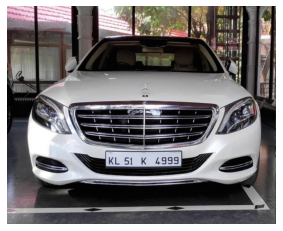

In [78]:
plt.imshow(image)
plt.axis('off')  # Optional: Turn off axis labels and ticks
plt.show()

In [79]:
# test_arr = image_arr_224.reshape(1,224,224,3)
test_arr.shape

(1, 224, 224, 3)

# DE-NORMALIZE THE OUTPUT

In [80]:
# Make predictions
coordinates = model.predict(test_arr)
coordinates

1/1 [==============================] - 3s 3s/step


array([[0.40488425, 0.62833476, 0.589764  , 0.72654116]], dtype=float32)

In [81]:
# Denormalize the values
denorm = np.array([w,w,h,h])
coordinates = coordinates * denorm
coordinates

array([[364.80070832, 566.12961936, 429.93795526, 529.64850676]])

# BOUNDING BOX

In [82]:
coordinates = coordinates.astype(np.int32)
coordinates

array([[364, 566, 429, 529]])

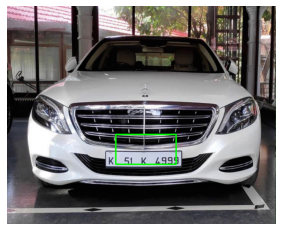

In [83]:
# Draw bounding on top the image
xmin, xmax,ymin,ymax = coordinates[0]
pt1 =(xmin,ymin)
pt2 =(xmax,ymax)

cv2.rectangle(image,pt1,pt2,(0,255,0),3)

plt.imshow(image)
plt.axis('off')  # Optional: Turn off axis labels and ticks
plt.show()

# CREATE PIPELINE

1/1 [==============================] - 0s 209ms/step
(364, 429) (566, 529)


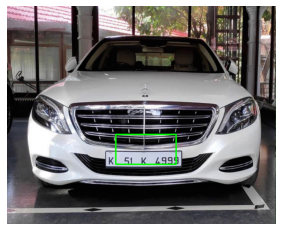

In [84]:
# Create pipeline
path = 'input/TEST/TEST.jpeg'
def object_detection(path):
    
    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))
    
    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)
    
    # Make predictions
    coordinates = model.predict(test_arr)
    
    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coordinates = coordinates * denorm
    coordinates = coordinates.astype(np.int32)
    
    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coordinates[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coordinates

image, cods = object_detection(path)

plt.imshow(image)
plt.axis('off')  # Optional: Turn off axis labels and ticks
plt.show()

# OPTICAL CHARACTER RECOGNITION - OCR


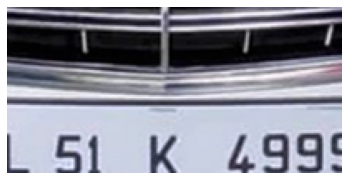

In [85]:
img = np.array(load_img(path))
xmin ,xmax,ymin,ymax = cods[0]
roi = img[ymin:ymax,xmin:xmax]

plt.imshow(roi)
plt.axis('off')  # Optional: Turn off axis labels and ticks
plt.show()